## Setup

In [1]:
%run setup.ipynb

In [2]:
import lmfit
from bisect import bisect_left, bisect_right

In [3]:
def exponential_peak(x, center, amplitude, decay, baseline, floor, ceiling):
    """Symmetric exponential peak function.

    Parameters
    ----------
    x : ndarray
        Independent variable.
    center : int or float
        The center of the peak.
    amplitude : float
        Amplitude parameter.
    decay : float
        Decay parameter.
    baseline : float
        Baseline parameter.
    floor : float
        Minimum value that the result can take.
    ceiling : float
        Maximum value that the result can take.

    Returns
    -------
    y : ndarray

    """

    # locate the index at which to split data into left and right flanks
    ix_split = bisect_right(x, center)

    # compute left flank
    xl = center - x[:ix_split]
    yl = baseline + amplitude * np.exp(-xl / decay)

    # compute right flank
    xr = x[ix_split:] - center
    yr = baseline + amplitude * np.exp(-xr / decay)

    # prepare output
    y = np.concatenate([yl, yr])

    # apply limits
    y = y.clip(floor, ceiling)

    return y


In [4]:
def tex_format_param(params, name):
    value = params[name].value
    stderr = params[name].stderr
    relerr = stderr * 100 / value
    return f"${name}={value:.3f}\\pm{stderr:.3f}$ $({relerr:.1f}\\%)$\n"


In [5]:
def iterative_exponential_peak_fit(peak_model, peak_params, y, x, n_iter, t=0.01):
    for i in range(n_iter):
        peak_result = peak_model.fit(y, x=x, params=peak_params.copy())
        n = peak_result.residual.shape[0]
        loc_keep = np.argsort(np.fabs(peak_result.residual))[:-int(t*n)]
        loc_keep.sort()
        x = x[loc_keep]
        y = y[loc_keep]
    return peak_result


In [7]:
@numba.njit
def hampel_filter(input_series, size, t=3):
    # https://link.springer.com/article/10.1186/s13634-016-0383-6
    # https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
    
    n = len(input_series)
    output_series = input_series.copy()
    mad_scale_factor = 1.4826
    
    for i in range(size, n - size):
        window = input_series[i - size:i + size]
        m = np.median(window)
        mad = np.median(np.abs(window - m))
        S = mad_scale_factor * mad
        if np.abs(input_series[i] - m) > (t * S):
            output_series[i] = m
    
    return output_series


In [40]:
def analyse_exponential_peak_fit(pop, chromosome, center, flank, locus, ax=None,
                                 median_filter_kws=None, hampel_filter_kws=None, 
                                 fit_iterations=None):
    
    # load gwss data
    pwindows, gwindows, _, signal, _, _ = load_h12_gwss(pop, chromosome)
    ppos = pwindows.mean(axis=1)
    gpos = gwindows.mean(axis=1)

    # locate center and region to fit
    loc_center = bisect_left(ppos, center)
    gcenter = gpos[loc_center]
    loc_region = slice(bisect_left(gpos, gcenter - flank), 
                       bisect_right(gpos, gcenter + flank))
    
    # filter
    if median_filter_kws:
        signal = scipy.ndimage.median_filter(signal, **median_filter_kws)
    if hampel_filter_kws:
        signal = hampel_filter(signal, **hampel_filter_kws)
        
    # setup data to fit
    x = gpos[loc_region]
    y = signal[loc_region]

    # fit peak model
    peak_model = lmfit.Model(exponential_peak)
    peak_params = lmfit.Parameters()
    peak_params['center'] = lmfit.Parameter('center', vary=True, value=gcenter)
    peak_params['amplitude'] = lmfit.Parameter('amplitude', vary=True, value=0.5, min=0, max=1)
    peak_params['decay'] = lmfit.Parameter('decay', vary=True, value=0.5, min=0.15, max=3.0)
    peak_params['baseline'] = lmfit.Parameter('baseline', vary=True, value=0.03, min=0, max=1)
    peak_params['ceiling'] = lmfit.Parameter('ceiling', vary=False, value=1)
    peak_params['floor'] = lmfit.Parameter('floor', vary=False, value=0)
    if fit_iterations:
        peak_result = iterative_exponential_peak_fit(peak_model, peak_params, y, x, 
                                                     n_iter=fit_iterations)
    else:
        peak_result = peak_model.fit(y, x=x, params=peak_params)

    # fit null model
    null_model = lmfit.models.ConstantModel()
    null_params = lmfit.Parameters()
    null_params['c'] = lmfit.Parameter('c', vary=True, value=0.03, min=0, max=1)
    null_result = null_model.fit(y, x=x, params=null_params)

    # plot
    if ax is None:
        fig, ax = plt.subplots(facecolor='w', figsize=(8, 3))
    peak_result.plot_fit(
        ax=ax, 
        xlabel=f'Chromosome {chromosome} position (cM)', 
        ylabel='$H12$',
        data_kws=dict(markersize=2), 
        fit_kws=dict(color='k', linestyle='--')
    )
    ax.axvline(bp2cm(chromosome, center), color='w', lw=2, zorder=0)
    ax.annotate(
        f'Model: exponential peak\n' +
        f'\nFit statistics:\n' + 
        f'$AIC={peak_result.aic:.0f}$\n' +
        f'$BIC={peak_result.bic:.0f}$\n' +
        f'$\\chi^{2}={peak_result.chisqr:.3f}$\n' +
        f'$\\Delta_{{i}}={null_result.aic - peak_result.aic:.0f}$\n' +
        f'\nVariables:\n' +
        tex_format_param(peak_result.params, 'amplitude') +
        tex_format_param(peak_result.params, 'decay') +
        tex_format_param(peak_result.params, 'baseline') +
        tex_format_param(peak_result.params, 'center')[:-1],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(5, -5), textcoords='offset points',
        va='top', ha='left', fontsize=8,
    )
    ax.set_title(f"{tex_math_species(pop_defs[pop]['label'])}; ${locus}$")
    
    fig_path = here() / 'artwork/expfit_{}'


## Analysis

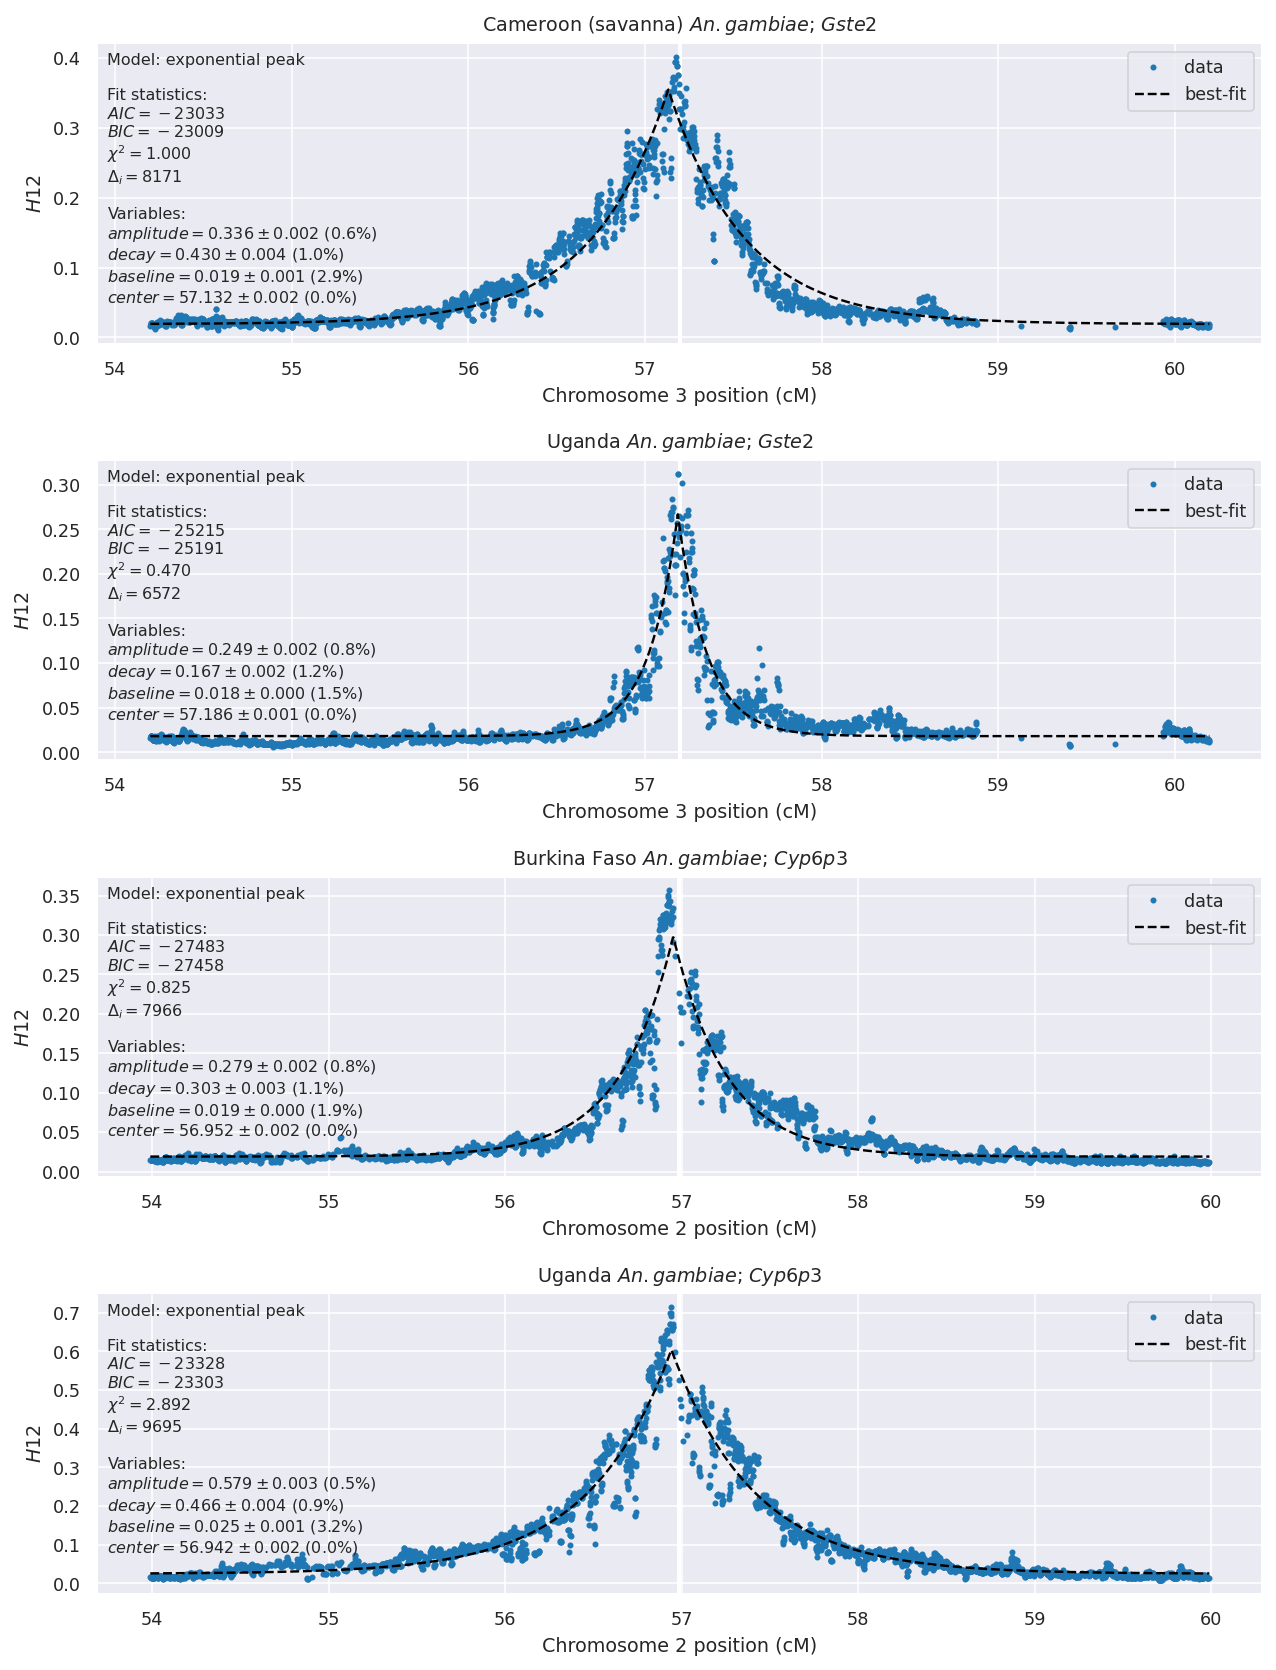

In [41]:
figw = 9
figh = (10.75/8.25) * figw

fig = plt.figure(facecolor='w', figsize=(figw, figh))

tracks = [
    ('cm_sav_gam', gste2, 3),
    ('ug_gam', gste2, 3),
    ('bf_gam', cyp6p3, 3),
    ('ug_gam', cyp6p3, 3),
]

nrows = len(tracks)

for i, (pop, gene, flank) in enumerate(tracks):

    ax = fig.add_subplot(nrows, 1, i+1)
    analyse_exponential_peak_fit(pop, 
                                 chromosome=gene.chromosome, 
                                 center=gene.chromosome_center, 
                                 flank=flank, 
                                 locus=gene.Name,
                                 ax=ax)

fig.tight_layout()
fig.savefig(here() / 'artwork/exponential_fit_examples.png', bbox_inches='tight',
            dpi=150)

## Sandbox

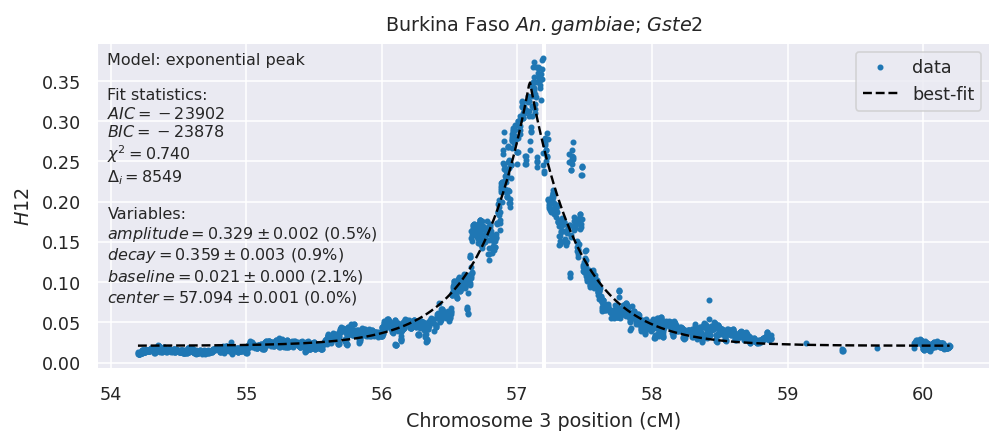

In [42]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name)

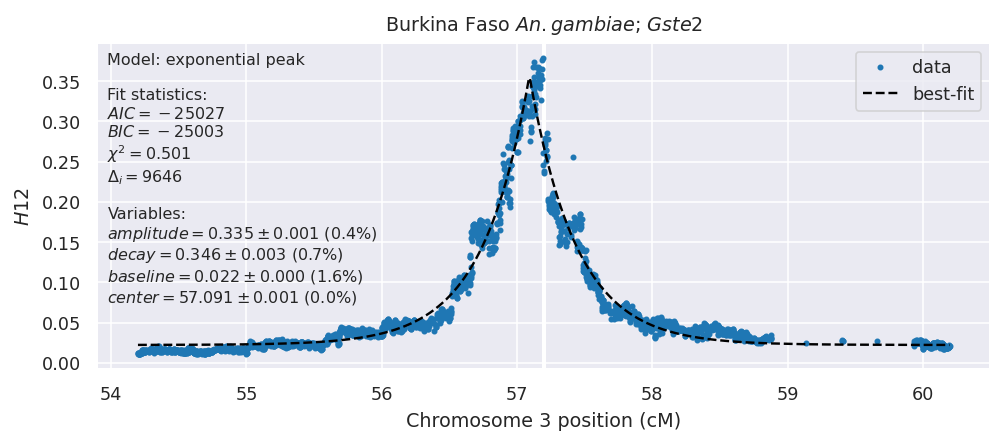

In [43]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             hampel_filter_kws=dict(size=20, t=2))

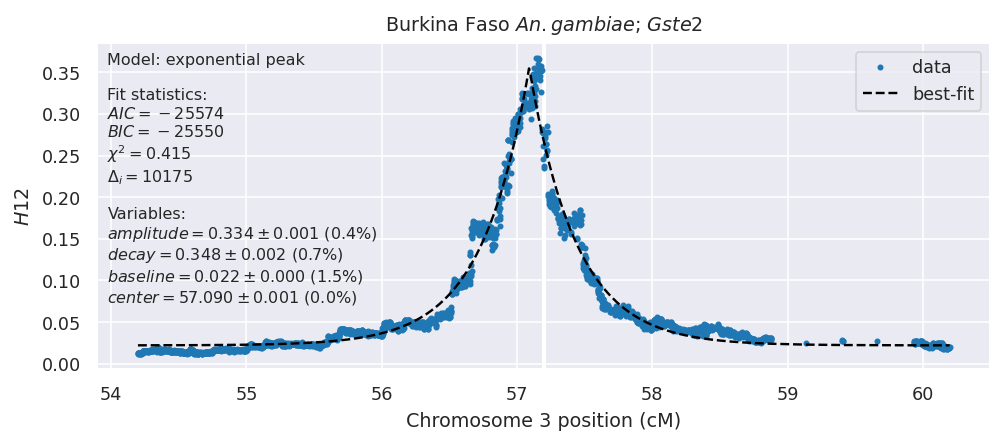

In [44]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             hampel_filter_kws=dict(size=20, t=1))

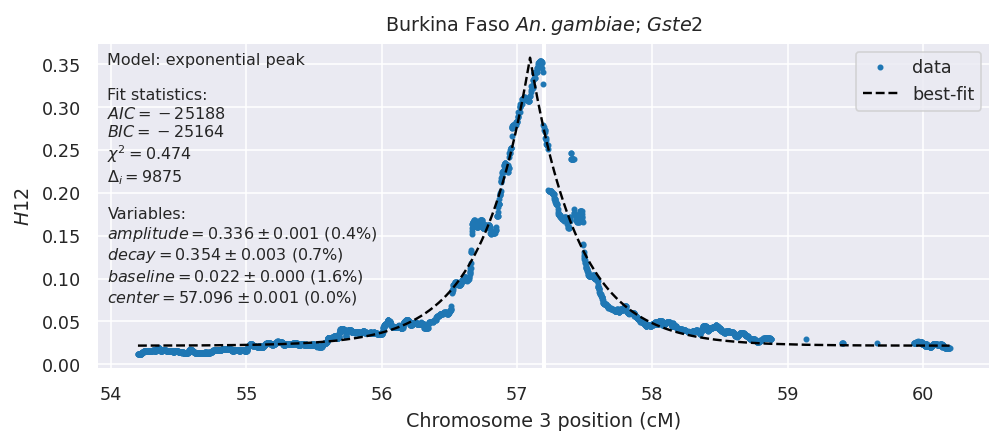

In [45]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             median_filter_kws=dict(size=20, mode='reflect'))

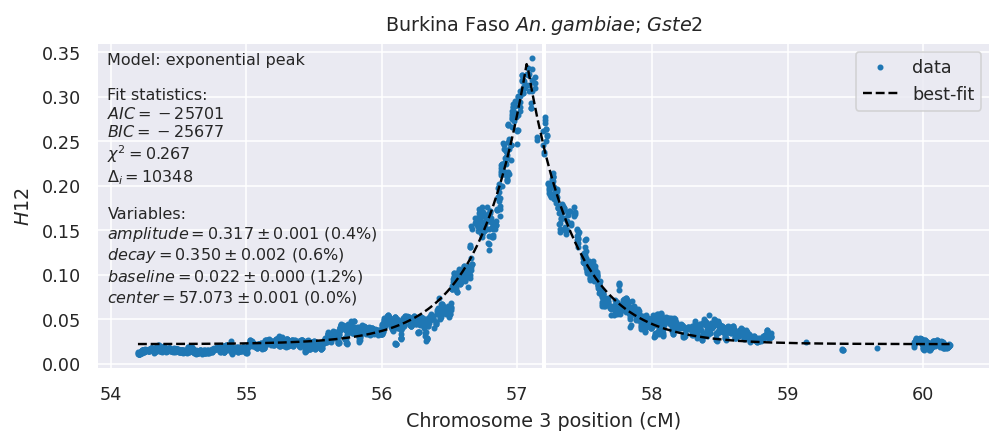

In [46]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             fit_iterations=5)

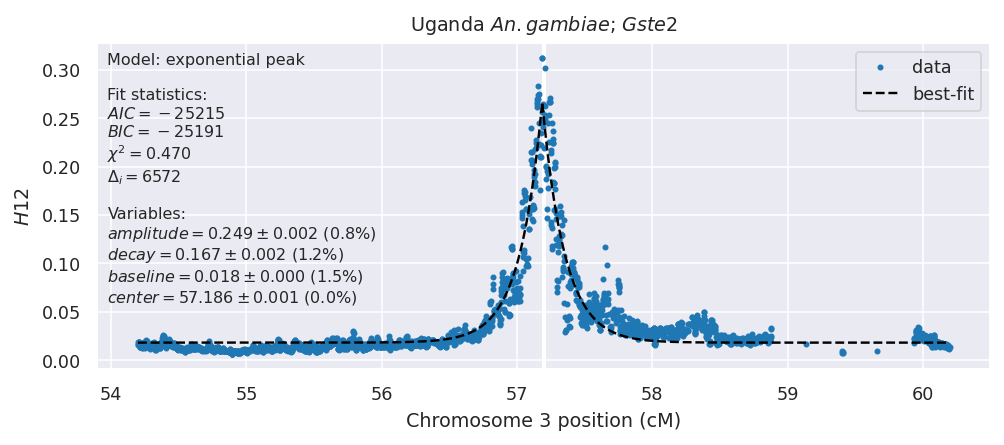

In [47]:
analyse_exponential_peak_fit('ug_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name)

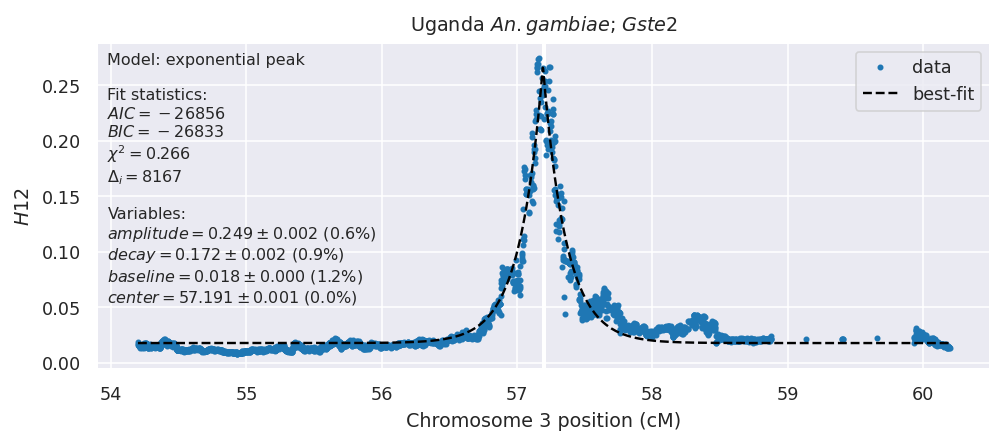

In [48]:
analyse_exponential_peak_fit('ug_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             hampel_filter_kws=dict(size=20, t=1))

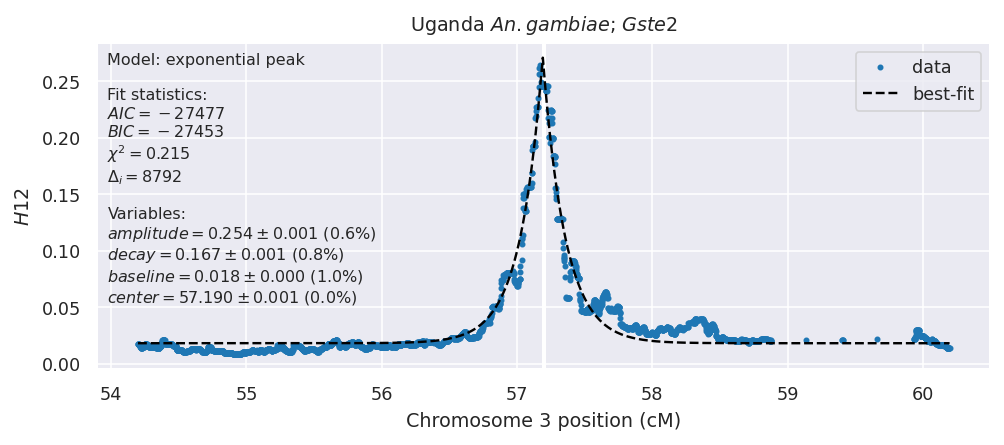

In [49]:
analyse_exponential_peak_fit('ug_gam', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             median_filter_kws=dict(size=20))

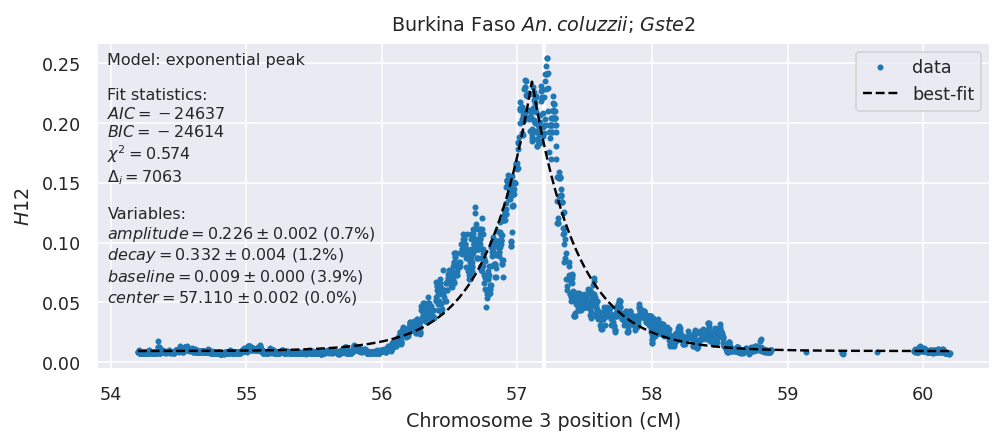

In [50]:
analyse_exponential_peak_fit('bf_col', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name)

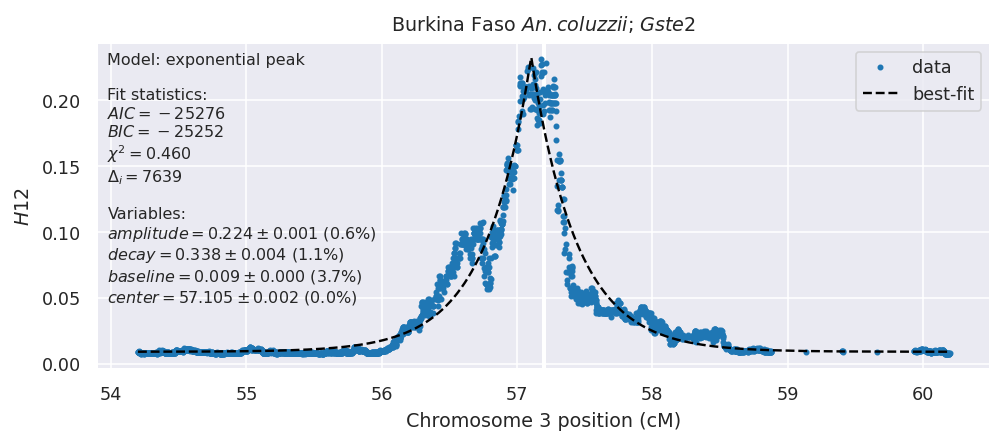

In [51]:
analyse_exponential_peak_fit('bf_col', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             hampel_filter_kws=dict(size=20, t=1))

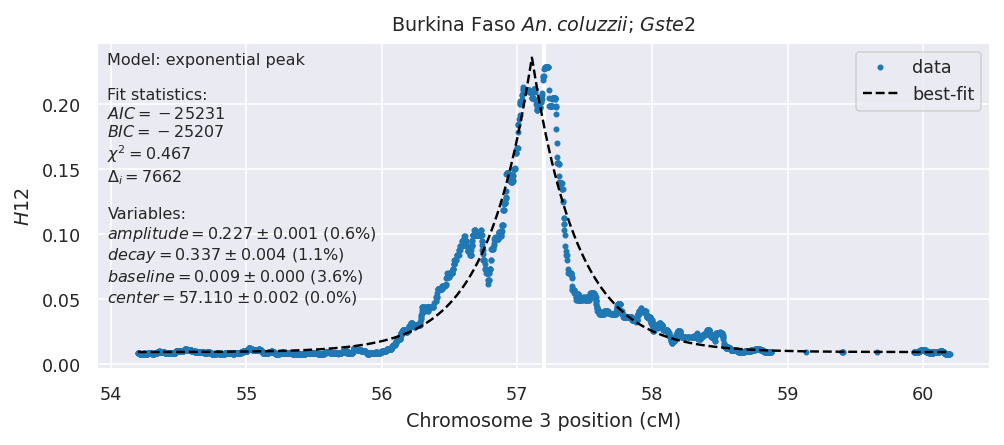

In [54]:
analyse_exponential_peak_fit('bf_col', 
                             chromosome=gste2.chromosome, 
                             center=gste2.chromosome_center, 
                             flank=3, 
                             locus=gste2.Name,
                             median_filter_kws=dict(size=20))

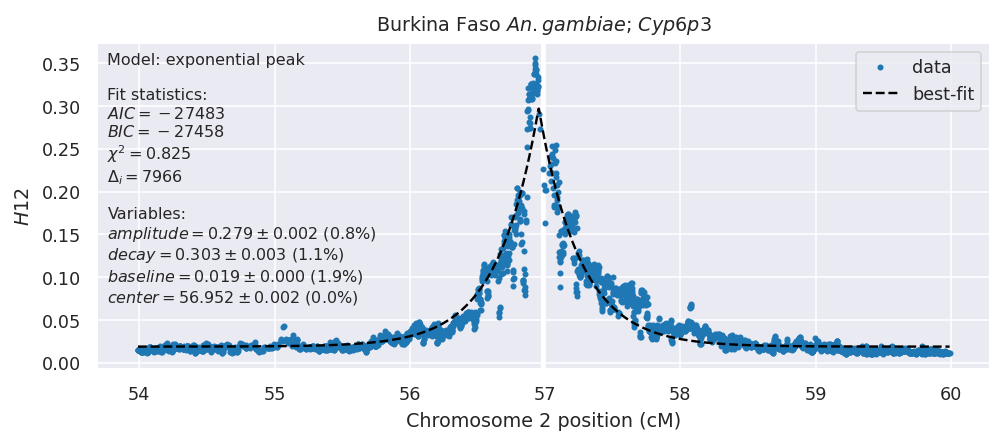

In [55]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=cyp6p3.chromosome, 
                             center=cyp6p3.chromosome_center, 
                             flank=3, 
                             locus=cyp6p3.Name)

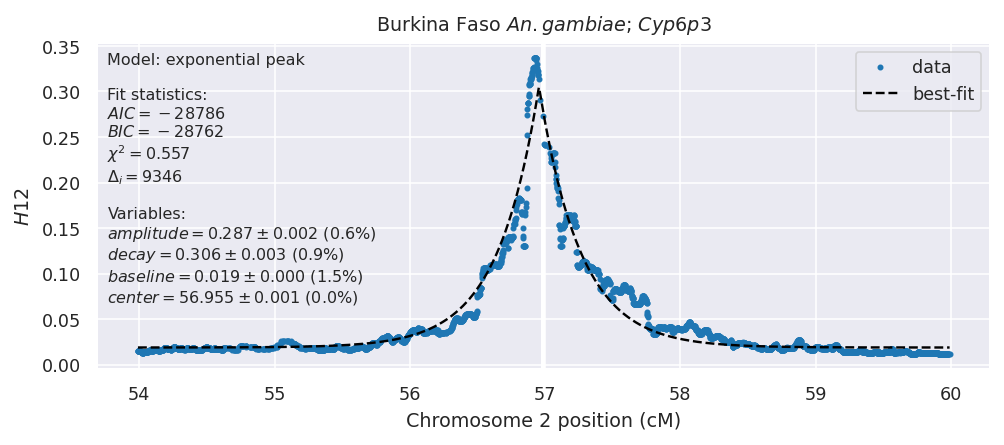

In [58]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=cyp6p3.chromosome, 
                             center=cyp6p3.chromosome_center, 
                             flank=3, 
                             locus=cyp6p3.Name, 
                             median_filter_kws=dict(size=20))

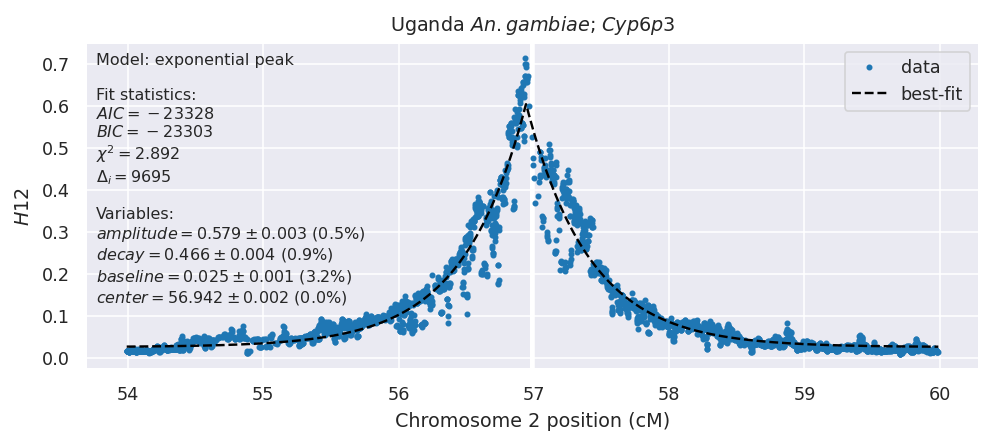

In [59]:
analyse_exponential_peak_fit('ug_gam', 
                             chromosome=cyp6p3.chromosome, 
                             center=cyp6p3.chromosome_center, 
                             flank=3, 
                             locus=cyp6p3.Name)

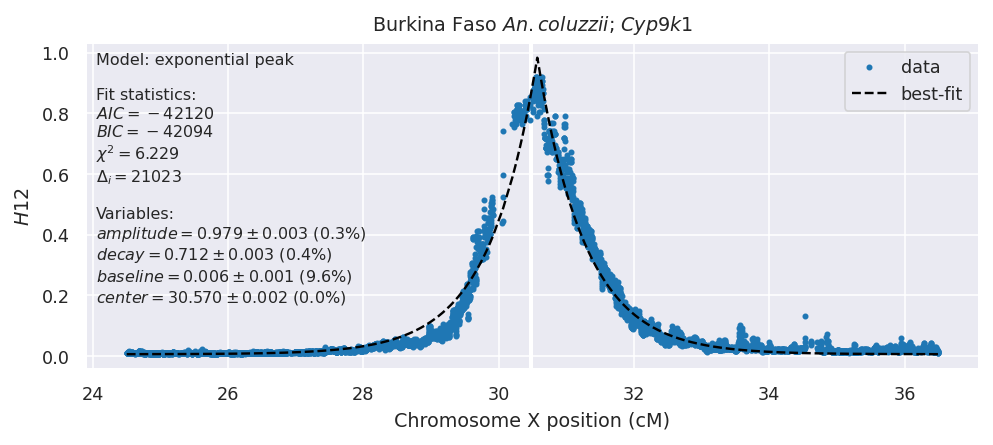

In [60]:
analyse_exponential_peak_fit('bf_col', 
                             chromosome=cyp9k1.chromosome, 
                             center=cyp9k1.chromosome_center, 
                             flank=6, 
                             locus=cyp9k1.Name)

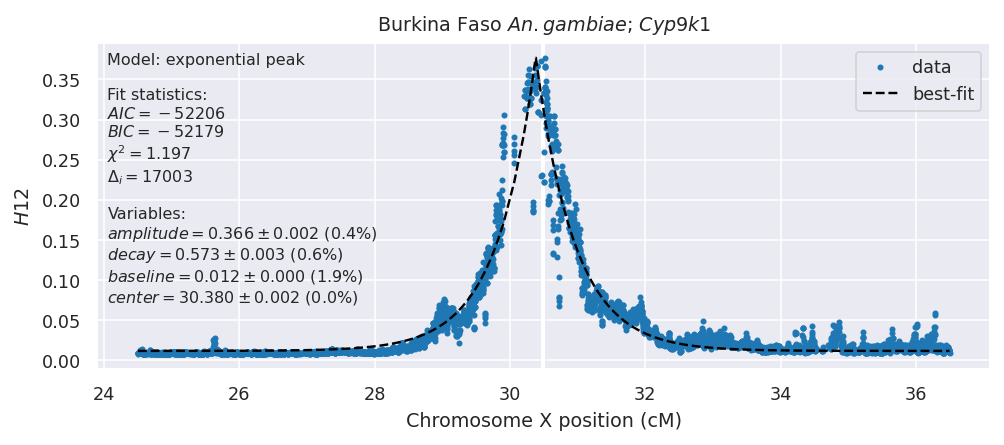

In [61]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=cyp9k1.chromosome, 
                             center=cyp9k1.chromosome_center, 
                             flank=6, 
                             locus=cyp9k1.Name)

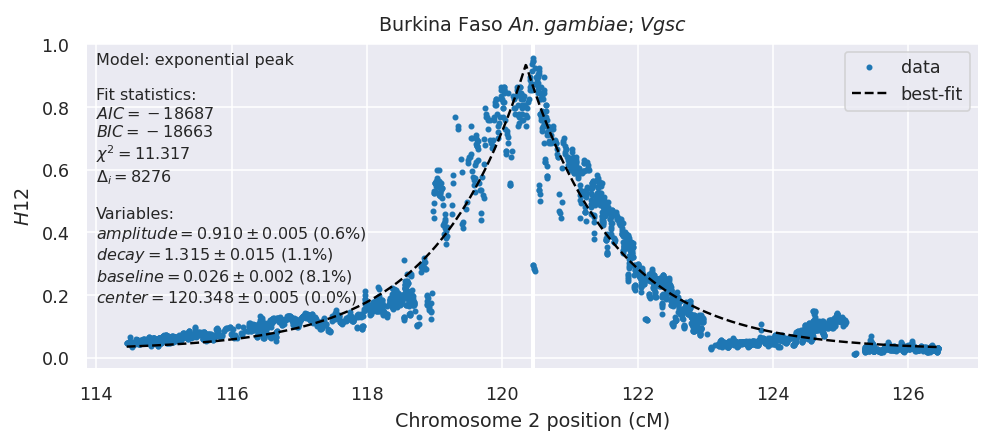

In [62]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=vgsc.chromosome, 
                             center=vgsc.chromosome_center, 
                             flank=6, 
                             locus=vgsc.Name)

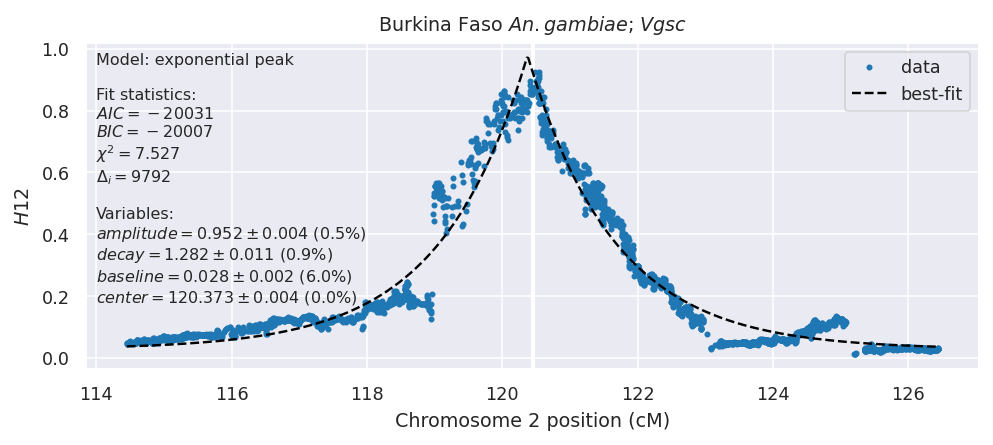

In [63]:
analyse_exponential_peak_fit('bf_gam', 
                             chromosome=vgsc.chromosome, 
                             center=vgsc.chromosome_center, 
                             flank=6, 
                             locus=vgsc.Name,
                             hampel_filter_kws=dict(size=20, t=1))